# **Phân tích hóa đơn điện tử**

Import các thư viện cần thiết

In [1]:
%unload_ext google.colab.data_table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

The google.colab.data_table extension is not loaded.


Đọc dữ liệu từ database và chuẩn hóa lại một số trường dữ liệu

In [2]:
df = pd.read_csv('/content/OnlineRetail.csv', encoding= 'unicode_escape')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Chúng ta sẽ chỉ xét những hóa đơn có số lượng > 0, với ý nghĩa là hóa đơn mua vào, sau đó tính tổng tiền của từng mã đã bỏ ra bằng cách nhân số lượng (quantity) với đơn giá (unitprice)

In [3]:
df['Cost'] = df['Quantity'] * df['UnitPrice']
buy = df
#buy = df.loc[df['Quantity'] > 0]

# Một số thông tin tiêu biểu về các mặt hàng

Top 5 mặt hàng được mua nhiều nhất:

In [55]:
sc = buy.groupby(['StockCode', 'Description'])['Quantity'].sum()
sc = sc.reset_index()
sc = sc.sort_values(by = ['Quantity'], ascending = False)
sc.head()

,StockCode,Description,Quantity
3617,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
4197,85099B,JUMBO BAG RED RETROSPOT,47363
3956,84879,ASSORTED COLOUR BIRD ORNAMENT,36381
1333,22197,POPCORN HOLDER,36334
531,21212,PACK OF 72 RETROSPOT CAKE CASES,36039


Tổng đã bán 2058 mặt hàng 

Thử xét mặt hàng bán chạy nhất đến từ quốc gia nào:

In [56]:
sc = buy.groupby(['StockCode', 'Description', 'Country'])['Quantity'].sum()
sc = sc.reset_index()
sc = sc.loc[sc['StockCode'] == '84077']
sc = sc.sort_values(by = ['Quantity'], ascending = False)
sc.head()

,StockCode,Description,Country,Quantity
18119,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,United Kingdom,48326
18117,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,Sweden,2304
18109,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,EIRE,816
18113,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,Japan,577
18110,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,France,528


Quốc gia thu mua nó nhiều nhất là UK, thử xem những khách hàng đã mua nó là ai



In [57]:
sc = buy.groupby(['StockCode', 'Description', 'Country', 'CustomerID'])['Quantity'].sum()
sc = sc.reset_index()
sc = sc.loc[sc['StockCode'] == '84077']
sc = sc.sort_values(by = ['Quantity'], ascending = False)
sc.head()

,StockCode,Description,Country,CustomerID,Quantity
244095,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,United Kingdom,16333.0,10080
243911,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,United Kingdom,12901.0,5712
244121,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,United Kingdom,16754.0,2880
244146,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,United Kingdom,17381.0,2640
243905,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,Sweden,17404.0,2304


Chỉ một khác hàng mà mua khá là nhiều sản phẩm, chúng ta xem thử khách hàng này thường mua những gì

In [65]:
stock_customer = buy.loc[buy['CustomerID'] == 16333].groupby(['StockCode','Description'])['Quantity'].sum().reset_index()
stock_customer

,StockCode,Description,Quantity
0,21704,BAG 250g SWIRLY MARBLES,504
1,21749,LARGE RED RETROSPOT WINDMILL,1176
2,21891,TRADITIONAL WOODEN SKIPPING ROPE,3456
3,21915,RED HARMONICA IN BOX,8120
4,22086,PAPER CHAIN KIT 50'S CHRISTMAS,1632
5,22440,BALLOON WATER BOMB PACK OF 35,3600
6,22620,4 TRADITIONAL SPINNING TOPS,640
7,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,2976
8,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,10080


Khách hàng này mua các mặt hàng như balo, dây, bóng bay nước, tàu lượng, giấy trang trí giáng sinh. Có thể đây là một cửa hàng bán đồ trang trí hoặc cắm trại cho mùa đông?

Top 5 đơn hàng có giá trị lớn nhất:

In [8]:
sorted_buy = buy.sort_values(by = ['Cost'], ascending = False)
sorted_buy.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cost
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-09-12 09:15:00,2.08,16446.0,United Kingdom,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-10-06 15:28:00,649.50,15098.0,United Kingdom,38970.00
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-07-12 15:08:00,13541.33,NaN,United Kingdom,13541.33
299982,A563185,B,Adjust bad debt,1,2011-12-08 14:50:00,11062.06,NaN,United Kingdom,11062.06


Ta thấy 3 trong số 5 mặt hàng này có thời gian mua hàng cách đây tầm 1 năm. Mặt hàng có tổng giá trị lớn nhất có đơn giá khá thấp còn 3 mặt hàng phía sau lại được mua với số lượng chỉ 1 nhưng đơn giá lại rất cao




Một số mặt hàng bị hủy:

In [9]:
cancel_buy = df.loc[df['Quantity'] < 0].sort_values(by = ['Cost'], ascending = True)
cancel_buy.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cost
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-09-12 09:27:00,2.08,16446.0,United Kingdom,-168469.60
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.60
222681,C556445,M,Manual,-1,2011-10-06 15:31:00,38970.00,15098.0,United Kingdom,-38970.00
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-05-12 11:36:00,17836.46,NaN,United Kingdom,-17836.46
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-05-01 09:55:00,16888.02,NaN,United Kingdom,-16888.02


Nhìn vào ta thấy được, tuy các đơn hàng ở phía trên có giá trị lớn nhưng mà sau đó lại bị gửi trả hết, vì vậy cho nên chúng lại không nằm trong các đơn hàng có tổng giá trị lớn nhất

Top 5 mặt hàng có tổng giá trị lớn nhất:

In [7]:
mn = buy.groupby(['StockCode', 'Description'])['Cost'].sum()
mn = mn.reset_index()
mn = mn.sort_values(by = ['Cost'], ascending = False)
mn.head()

,StockCode,Description,Cost
4780,DOT,DOTCOM POSTAGE,206245.48
1554,22423,REGENCY CAKESTAND 3 TIER,164762.19
3295,47566,PARTY BUNTING,98302.98
4223,85123A,WHITE HANGING HEART T-LIGHT HOLDER,97715.99
4197,85099B,JUMBO BAG RED RETROSPOT,92356.03


Biểu đồ thể hiện sự phân bố tổng số tiền mua các mặt hàng

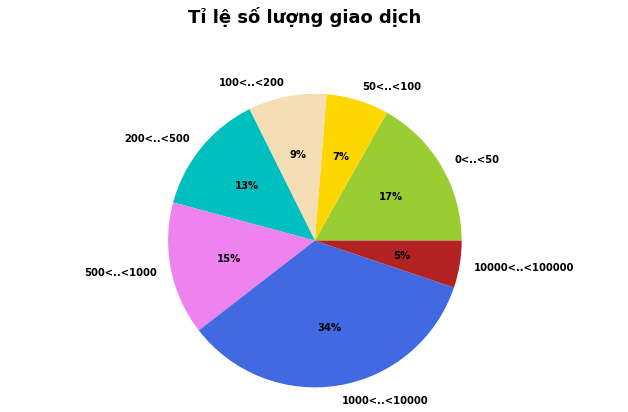

In [10]:
#Đếm số lượng của từng giá trị đơn hàng
price_range = [0, 50, 100, 200, 500, 1000, 10000, 100000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = mn[(mn['Cost'] < price) & (mn['Cost'] > price_range[i-1])]['Cost'].count()
    count_price.append(val)
     
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<..<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors, autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '', shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01,"Tỉ lệ số lượng giao dịch", ha='center', fontsize = 18);

# Phân tích và vẽ biểu đồ theo các quốc gia

Tính tổng chi:

In [11]:
TotalCost = buy.groupby('Country')['Cost'].sum()
TotalCost = TotalCost.reset_index()
TotalCost

,Country,Cost
0,Australia,137077.270
1,Austria,10154.320
2,Bahrain,548.400
3,Belgium,40910.960
4,Brazil,1143.600
5,Canada,3666.380
6,Channel Islands,20086.290
7,Cyprus,12946.290
8,Czech Republic,707.720
9,Denmark,18768.140


Tổng số lượng sản phẩm đã mua:

In [12]:
AmountInvoice = buy.groupby('Country')['InvoiceNo'].count()
AmountInvoice = AmountInvoice.reset_index()
AmountInvoice

,Country,InvoiceNo
0,Australia,1259
1,Austria,401
2,Bahrain,19
3,Belgium,2069
4,Brazil,32
5,Canada,151
6,Channel Islands,758
7,Cyprus,622
8,Czech Republic,30
9,Denmark,389


Ngày cuối cùng mà khách đã mua hàng (chúng ta sẽ lấy ngày hiện tại là ngày của khách hàng mua hàng gần đây nhất):

In [13]:
LastDate = max(buy['InvoiceDate'])
LastDate += pd.DateOffset(days = 1)
buy['Distance'] = LastDate - buy['InvoiceDate']

recent = buy.groupby('Country')['Distance'].min()
recent.reset_index()
recent

Country
Australia                3 days 03:00:00
Austria                  4 days 07:15:00
Bahrain                 97 days 03:30:00
Belgium                  3 days 04:04:00
Brazil                 240 days 06:54:00
Canada                  34 days 06:46:00
Channel Islands         11 days 02:12:00
Cyprus                  10 days 04:36:00
Czech Republic          23 days 01:34:00
Denmark                 10 days 23:57:00
EIRE                     1 days 03:11:00
European Community      66 days 07:45:00
Finland                  1 days 00:19:00
France                   1 days 02:33:00
Germany                  1 days 05:18:00
Greece                  34 days 02:28:00
Hong Kong                7 days 07:51:00
Iceland                 41 days 04:54:00
Israel                  71 days 07:21:00
Italy                   11 days 00:42:00
Japan                   12 days 01:27:00
Lebanon                318 days 07:00:00
Lithuania              486 days 02:36:00
Malta                   18 days 03:37:00
Netherla

Ở trên là 3 bảng riêng biệt nhau thể hiện từng loại thông tin khác nhau, chúng ta cần tiến hành ghép các bảng lại thành một bảng để có thể xử lí

In [14]:
NewRetail = TotalCost.merge(AmountInvoice, on = 'Country')
NewRetail = NewRetail.merge(recent, on = 'Country')
NewRetail.columns = ['Country', 'MoneySpent', 'InvoiceAmount', 'LastTimePurchased']
NewRetail

,Country,MoneySpent,InvoiceAmount,LastTimePurchased
0,Australia,137077.270,1259,3 days 03:00:00
1,Austria,10154.320,401,4 days 07:15:00
2,Bahrain,548.400,19,97 days 03:30:00
3,Belgium,40910.960,2069,3 days 04:04:00
4,Brazil,1143.600,32,240 days 06:54:00
5,Canada,3666.380,151,34 days 06:46:00
6,Channel Islands,20086.290,758,11 days 02:12:00
7,Cyprus,12946.290,622,10 days 04:36:00
8,Czech Republic,707.720,30,23 days 01:34:00
9,Denmark,18768.140,389,10 days 23:57:00


Trên đây là thông tin tính được theo từng quốc gia, nhìn vào chúng ta có thể thấy lượng sản phẩm và số tiền đã chi của Anh quá lớn so với các quốc gia còn lại, nên đễ dễ dàng phân tích chúng ta sẽ loại quốc gia này ra

In [15]:
nr = NewRetail.loc[NewRetail['Country'] != 'United Kingdom']
#làm tròn ngày
nr['LastTimePurchased'] = nr['LastTimePurchased'].dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Sử dụng thuật toán KMeans để chia nhóm các quốc gia**




Đầu tiên chúng ta sẽ bỏ cột tên quốc gia đi vì dữ liệu này không thể chuyển thành kiểu float có thể vẽ biểu đồ

In [16]:
delName = pd.DataFrame(nr , columns=['MoneySpent', 'InvoiceAmount', 'LastTimePurchased'])

Sau đó chúng ta vẽ biểu đồ theo dõi sự thay đổi theo số lượng cụm để tiến hành chọn số lượng cụm hợp lí

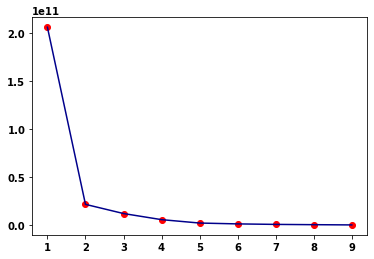

In [17]:
ssd = []
for k in range(1,10):

    km = KMeans(n_clusters=k)
	
    km.fit(delName)
	
    ssd.append(km.inertia_)
	
plt.plot(np.arange(1,10), ssd,color="darkblue")

plt.scatter(np.arange(1,10), ssd,color="red")

plt.show()



Chia nhóm với số lượng cụm là 4 

In [18]:
model = KMeans(n_clusters=4)
ClusterID = model.fit_predict(delName)
delName["ClusterID"] = ClusterID + 1

Sau đó chúng ta vẽ biểu đồ, 3 biểu đồ tương ứng với số tiền chi, số sản phẩm đã mua và ngày gần nhất mua hàng

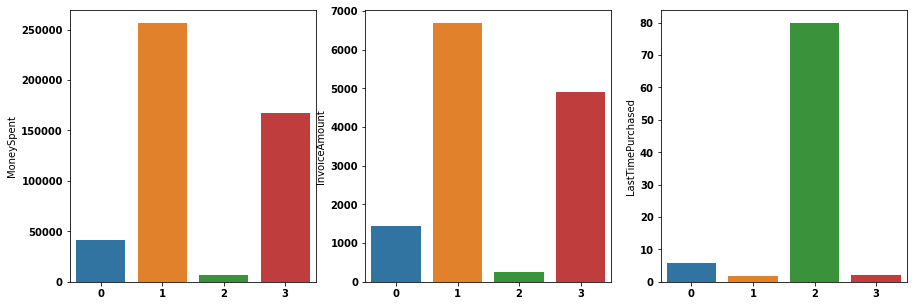

In [19]:
moneyspent =delName.groupby("ClusterID")['MoneySpent'].mean()

invoiceamount =delName.groupby("ClusterID")['InvoiceAmount'].mean()

lastime =delName.groupby("ClusterID")['LastTimePurchased'].mean()

fig, axs = plt.subplots(1,3, figsize = (15, 5))


sns.barplot(x = [0,1,2,3],  y = moneyspent , ax = axs[0])

sns.barplot(x = [0,1,2,3],  y = invoiceamount , ax = axs[1])

sns.barplot(x = [0,1,2,3],  y = lastime , ax = axs[2])

plt.show()



Chúng ta sẽ phân loại ra được 5 nhóm quốc gia đó là: 
  - Những quốc gia có lượng tiêu thụ, tổng giá trị mặt hàng thấp nhất và có lần cuối mua hàng cách đây hơn 3 tháng
  - Những quốc gia có giá trị đơn hàng trung bình, số lượng hàng mua cao nhất, lần cuối mua hàng rất gần
  - Những quốc gia có giá trị đơn hàng cao nhất, số lượng hàng mua khá cao, lần cuối mua hàng cũng rất gần đây
  - Những quốc gia có giá trị đơn hàng khá thấp, số lượng hàng cũng khá thấp, lần cuối mua hàng gần 1 tháng
  - Anh 

# Phân loại các mặt hàng theo tên

Đầu tiên là import thêm các thư viện cần thiết

In [20]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Chúng ta sẽ gom ra list gồm các từ khóa quan trọng thông qua NLP

In [21]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [22]:
df_produits = pd.DataFrame(buy['Description'].unique()).rename(columns = {0:'Description'})

In [23]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1603


In [24]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

In ra biểu đồ tỉ lệ xuất hiện của các từ khóa đó

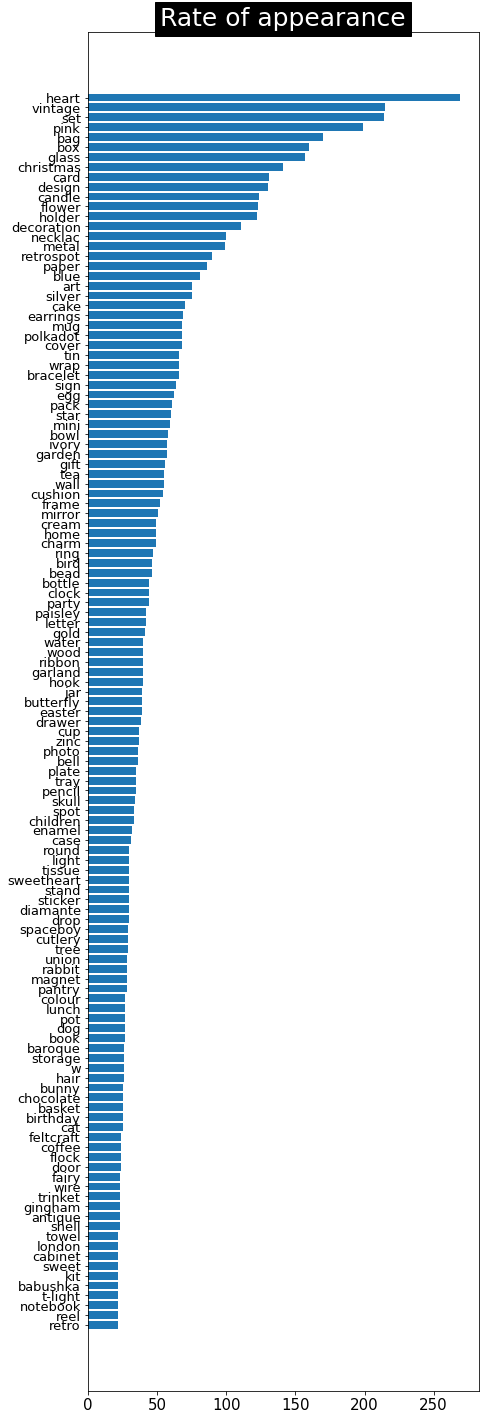

In [25]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Rate of appearance",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

Chúng ta đã lọc ra các từ ngữ đặc trưng tiêu biểu, tuy nhiên trong đó có thể lẫn một số từ miêu tả đặc tính ví dụ như màu sắc, hay là những từ có số lần xuất hiện rất ít, chúng ta sẽ loại nó ra. Chúng ta chỉ chọn những từ có số lần xuất hiện > 13 lần

In [26]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)

Dựa trên từ khóa, chúng ta sẽ có danh sách các từ có thể là tên các loại mặt hàng:

In [27]:
for x in list_products:
  print(x[0], end = ', ')

heart, vintage, set, bag, box, glass, christmas, card, design, candle, flower, holder, decoration, necklac, metal, retrospot, paper, art, silver, cake, earrings, mug, polkadot, cover, tin, wrap, bracelet, sign, egg, pack, star, mini, bowl, ivory, garden, gift, tea, wall, cushion, frame, mirror, cream, home, charm, ring, bird, bead, bottle, clock, party, paisley, letter, gold, water, wood, ribbon, garland, hook, jar, butterfly, easter, drawer, cup, zinc, photo, bell, plate, tray, pencil, skull, spot, children, enamel, case, round, light, tissue, sweetheart, stand, sticker, diamante, drop, spaceboy, cutlery, tree, union, rabbit, magnet, pantry, colour, lunch, pot, dog, book, baroque, storage, hair, bunny, chocolate, basket, birthday, cat, feltcraft, coffee, flock, door, fairy, wire, trinket, gingham, antique, shell, towel, london, cabinet, sweet, kit, babushka, t-light, notebook, reel, retro, number, jack, woodland, strawberry, wicker, ball, apple, tube, daisy, hanger, hand, kitchen, pur

# Biểu đồ biến động theo từng tháng

Để phân tích giá cả theo tháng, chúng ta cần chia cột thời gian thành cột ngày tháng năm.

In [28]:
datetime = buy
datetime['Year'] = datetime['InvoiceDate'].dt.year
datetime['Month'] = datetime['InvoiceDate'].dt.month
datetime['Day'] = datetime['InvoiceDate'].dt.day
datetime = datetime.loc[datetime['Quantity'] > 0]
datetime.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cost,Distance,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,698 days 08:53:00,2010,1,12
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,698 days 08:53:00,2010,1,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,698 days 08:53:00,2010,1,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,698 days 08:53:00,2010,1,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,698 days 08:53:00,2010,1,12


Sau đó là tổng tiền từng tháng trong năm 2010

In [29]:
per_month = datetime.loc[datetime['Year'] == 2010]
per_month = per_month.groupby(['Month'])['Cost'].sum().reset_index()
per_month

,Month,Cost
0,1,58960.79
1,2,47748.38
2,3,46943.71
3,5,31774.95
4,6,54830.46
5,7,99618.20
6,8,45389.98
7,9,53586.18
8,10,59182.92
9,12,325710.57


Sau đó là vẽ biểu đồ theo dõi sự biến động

Text(0, 0.5, 'Revenue in Millions')

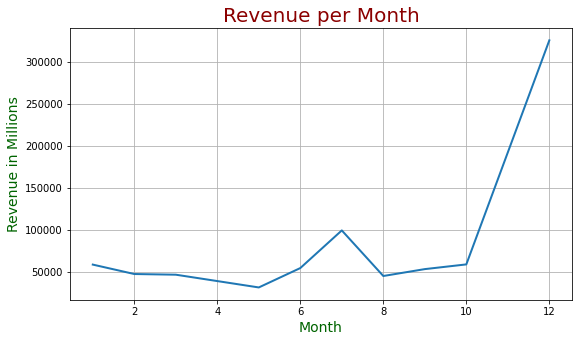

In [30]:
per_month.plot(x='Month', y='Cost', figsize = (9,5), grid = True, legend = None,
                      linewidth = 2)
plt.title('Revenue per Month', fontsize = 20, color = 'darkred')
plt.xlabel('Month',fontsize = 14, color = 'darkgreen')
plt.ylabel('Revenue in Millions', fontsize = 14, color ='darkgreen')

Và chúng ta cùng xem xét tỉ lệ tăng trưởng của nó:

In [31]:
per_month['Growth_Rate_Monthly'] =  per_month['Cost'].pct_change().round(4)*100
per_month['Growth_Rate_Monthly'] = per_month['Growth_Rate_Monthly'].fillna(0)
per_month

,Month,Cost,Growth_Rate_Monthly
0,1,58960.79,0.00
1,2,47748.38,-19.02
2,3,46943.71,-1.69
3,5,31774.95,-32.31
4,6,54830.46,72.56
5,7,99618.20,81.68
6,8,45389.98,-54.44
7,9,53586.18,18.06
8,10,59182.92,10.44
9,12,325710.57,450.35


Vừa rồi là thông tin về số tiền thu nhập theo từng tháng, tiếp đến chúng ta sẽ phân tích về số lượng khách hàng và đơn hàng:

**Khách hàng:**

In [32]:
Customer_month = datetime.groupby(['Month']).agg({'CustomerID':'nunique'}).sort_values(by="Month" , ascending = True).reset_index()
Customer_month = Customer_month.rename(columns={'CustomerID':'Customers'})
Customer_month

,Month,Customers
0,1,930
1,2,872
2,3,968
3,4,890
4,5,1046
5,6,1079
6,7,1111
7,8,1010
8,9,1244
9,10,1279


Text(0, 0.5, 'Customers')

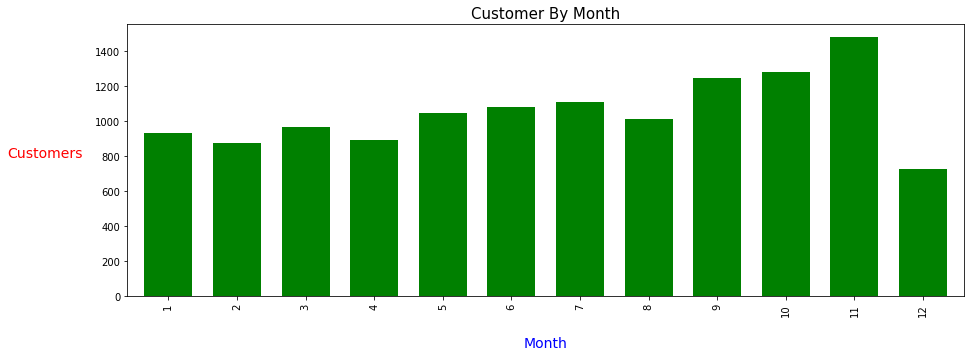

In [33]:
Customer_month.plot(x='Month', y='Customers', kind='bar',
        figsize=(15,5), legend=False, width = .7, color = ['Green'])
plt.title('Customer By Month', fontsize=15);
plt.xlabel('Month' , fontsize = 14, color = 'Blue', labelpad = 20)
plt.ylabel('Customers', rotation = 0, fontsize = 14, labelpad = 50, color = 'Red')

**Số lượng đơn hàng:**

In [34]:
SKU_by_Month = datetime.groupby(['Month']).agg({'StockCode':'nunique'}).sort_values(by = 'Month',ascending = True).reset_index()
SKU_by_Month

,Month,StockCode
0,1,3183
1,2,3057
2,3,3098
3,4,3105
4,5,3146
5,6,3197
6,7,3224
7,8,3153
8,9,3157
9,10,3206


Text(0, 0.5, 'StockCode')

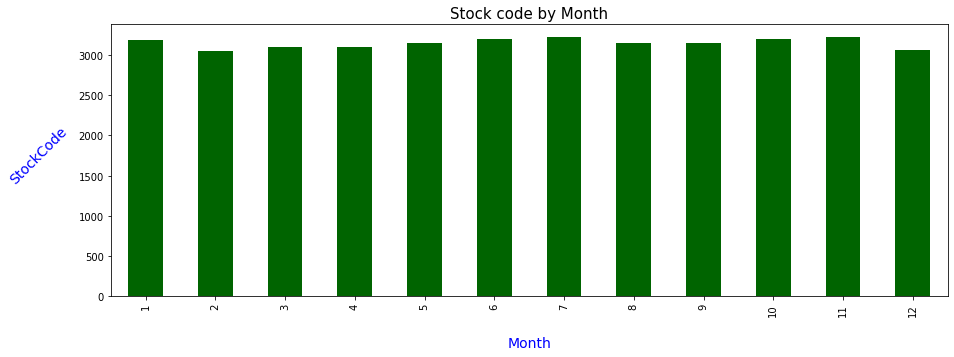

In [35]:
SKU_by_Month.plot(x='Month', y = 'StockCode', kind='bar',
        figsize=(15,5), legend=False, width = .5, color = ["darkgreen"])
plt.title('Stock code by Month', fontsize=15);
plt.xlabel('Month' , fontsize = 14, color = 'Blue', labelpad = 20)
plt.ylabel('StockCode', rotation = 45, fontsize = 14, labelpad = 35, color = 'Blue')

**Giá trị trung bình các đơn hàng trong từng tháng:**


In [36]:
Monthly_avg = datetime.groupby('Month').agg({'Cost' : 'mean'}).reset_index()
Monthly_avg

,Month,Cost
0,1,19.555083
1,2,18.753320
2,3,21.289137
3,4,19.414469
4,5,20.497803
5,6,18.755960
6,7,21.831669
7,8,18.199657
8,9,25.017360
9,10,19.502161


Text(0, 0.5, 'Revenue')

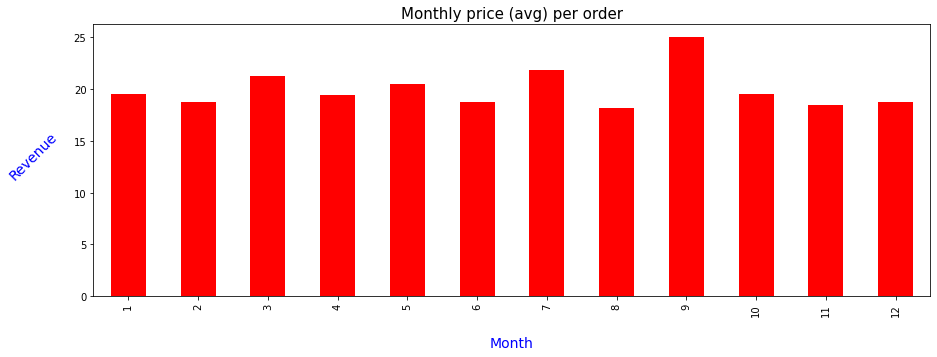

In [37]:
Monthly_avg.plot(x='Month', y = 'Cost', kind='bar', figsize=(15,5), legend=False, width = .5, color = ["red"])
plt.title('Monthly price (avg) per order', fontsize=15);
plt.xlabel('Month' , fontsize = 14, color = 'Blue', labelpad = 20)
plt.ylabel('Revenue', rotation = 45, fontsize = 14, labelpad = 35, color = 'Blue')